In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

C:\Users\HP 14\Miniconda3\envs\jcopml\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# Import Data

In [2]:
df = pd.read_csv("data/small_mnist.csv")
df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.iloc

# Dataset Splitting

In [4]:
X = df.drop(columns="label").values/255
y = df.label.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 784), (400, 784), (1600,), (400,))

# Visualize Random Data

In [5]:
import matplotlib.pyplot as plt

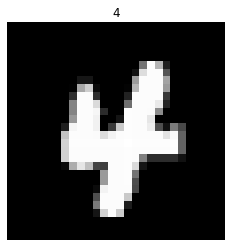

In [6]:
N = len(X_train)
idx = np.random.choice(N)
img, label = X_train[idx], y_train[idx]

plt.imshow(img.reshape(28, 28), cmap='gray')
plt.title(label)
plt.axis('off');

# Training

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

C:\Users\HP 14\Miniconda3\envs\jcopml\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\Users\HP 14\Miniconda3\envs\jcopml\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [8]:
df.label.value_counts()

9    200
8    200
7    200
6    200
5    200
4    200
3    200
2    200
1    200
0    200
Name: label, dtype: int64

In [9]:
pipeline = Pipeline([
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.3min finished


{'algo__max_depth': 22, 'algo__max_features': 0.1185260448662222, 'algo__min_samples_leaf': 2, 'algo__n_estimators': 187}
0.999375 0.9025057795953932 0.9275


# Visualize Prediction 

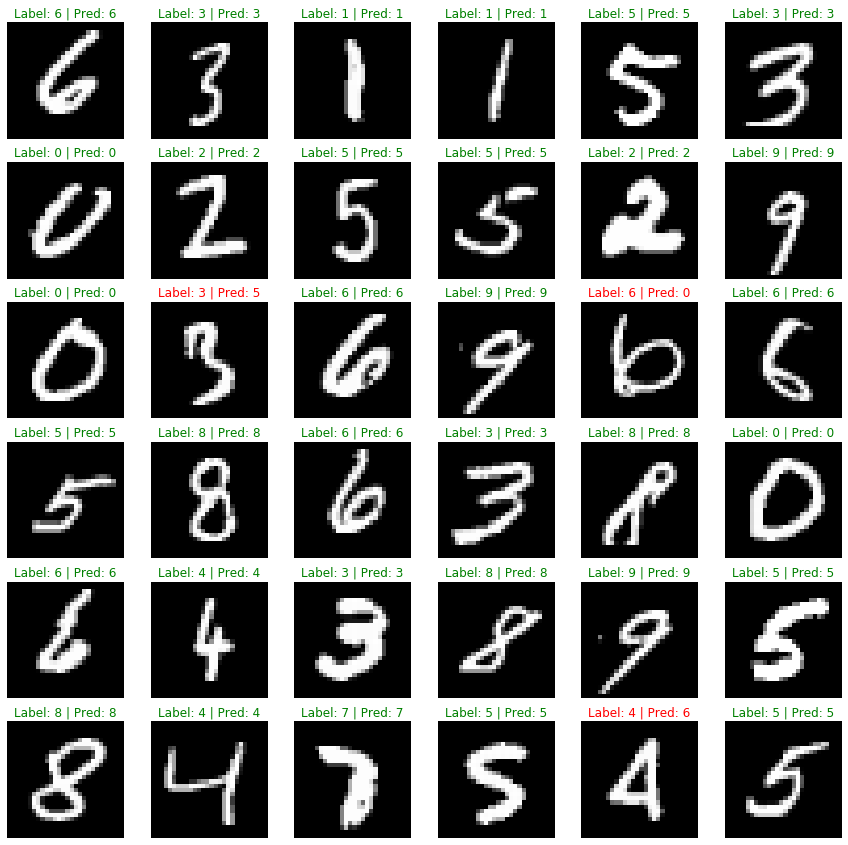

In [10]:
idx = np.random.choice(len(X_test), size=36, replace=False)
images, labels = X_test[idx], y_test[idx]
preds = model.predict(images)

fig, axes = plt.subplots(6, 6, figsize=(15, 15))
for img, label, pred, ax in zip(images, labels, preds, axes.flatten()):
    font = {"color": "g"} if label == pred else {"color": "r"}    
    
    ax.imshow(img.reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {label} | Pred: {pred}", fontdict=font)
    ax.axis('off');

# Why it works?

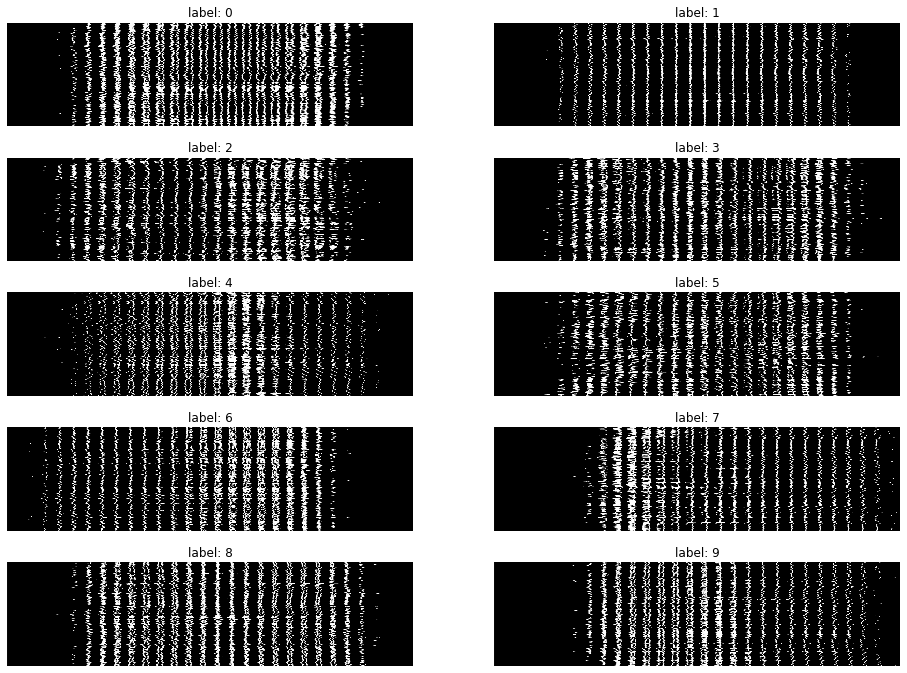

In [11]:
fig, axes = plt.subplots(5, 2, figsize=(16, 12))

for idx, ax in enumerate(axes.flatten()):
    ax.imshow(df.iloc[idx*200:(idx+1)*200], cmap='gray')
    ax.set_title(f"label: {idx}")
    ax.axis('off')